## 1. Setup & Imports

In [1]:
import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Project imports
import sys
sys.path.insert(0, str(Path().resolve().parent.parent))

from src.models.unet import UNet
from src.losses.combined_loss import CombinedLoss
from src.training.dataset import get_dataloaders
from src.degradations.generate_degraded_dataset import generate_degraded_dataset

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.9.1+cu130
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4070 SUPER
CUDA memory: 12.88 GB


## 2. Configuration

In [ ]:
# Training configuration
config = {
    # Data
    'train_degraded_dir': '../../data/degraded/DIV2K_train_HR',
    'train_clean_dir': '../../data/raw/DIV2K_train_HR',
    'val_degraded_dir': '../../data/degraded/DIV2K_valid_HR',
    'val_clean_dir': '../../data/raw/DIV2K_valid_HR',
    
    # Training
    'batch_size': 16,
    'num_epochs': 50,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    
    # Data
    'patch_size': 128,
    'patches_per_image': 10,
    'num_workers': 4,
    
    # Model
    'model_features': 64,
    'model_bilinear': True,
    
    # Loss
    'loss_alpha': 0.84,  # L1 weight
    'loss_beta': 0.16,   # SSIM weight
    
    # Optimization
    'scheduler': 'cosine',
    'warmup_epochs': 5,
    'min_lr': 1e-6,
    
    # Early stopping
    'patience': 5,
    
    # Checkpoints
    'save_every': 5,
    'val_every': 1,
    
    # Device
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'seed': 42
}

# Set seed for reproducibility
torch.manual_seed(config['seed'])
np.random.seed(config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed(config['seed'])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("\n📋 Configuration:")
for key, value in config.items():
    print(f"   {key}: {value}")


📋 Configuration:
   train_degraded_dir: ../../data/degraded/DIV2K_train_HR
   train_clean_dir: ../../data/raw/DIV2K_train_HR
   val_degraded_dir: ../../data/degraded/DIV2K_valid_HR
   val_clean_dir: ../../data/raw/DIV2K_valid_HR
   batch_size: 16
   num_epochs: 50
   learning_rate: 0.0001
   weight_decay: 1e-05
   patch_size: 128
   patches_per_image: 10
   num_workers: 4
   model_features: 64
   model_bilinear: True
   loss_alpha: 0.84
   loss_beta: 0.16
   scheduler: cosine
   warmup_epochs: 5
   min_lr: 1e-06
   patience: 10
   save_every: 5
   val_every: 1
   device: cuda
   seed: 42


## 3. Create Output Directories

In [3]:
# Create experiment directory
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
exp_name = f"unet_dithering_{timestamp}"
exp_dir = Path(f"../../experiments/results/{exp_name}")
exp_dir.mkdir(parents=True, exist_ok=True)

# Create subdirectories
checkpoints_dir = exp_dir / 'checkpoints'
samples_dir = exp_dir / 'samples'
logs_dir = exp_dir / 'logs'

checkpoints_dir.mkdir(exist_ok=True)
samples_dir.mkdir(exist_ok=True)
logs_dir.mkdir(exist_ok=True)

# Save configuration
with open(exp_dir / 'config.json', 'w') as f:
    json.dump(config, f, indent=2)

print(f"\n📁 Experiment directory: {exp_dir}")
print(f"   Checkpoints: {checkpoints_dir}")
print(f"   Samples: {samples_dir}")
print(f"   Logs: {logs_dir}")


📁 Experiment directory: ..\..\experiments\results\unet_dithering_20251228_152727
   Checkpoints: ..\..\experiments\results\unet_dithering_20251228_152727\checkpoints
   Samples: ..\..\experiments\results\unet_dithering_20251228_152727\samples
   Logs: ..\..\experiments\results\unet_dithering_20251228_152727\logs


## 4. Setup TensorBoard

In [4]:
# TensorBoard writer
writer = SummaryWriter(log_dir=logs_dir)

print(f"\n📊 TensorBoard logs: {logs_dir}")
print(f"   Run: tensorboard --logdir {logs_dir.absolute()}")


📊 TensorBoard logs: ..\..\experiments\results\unet_dithering_20251228_152727\logs
   Run: tensorboard --logdir c:\Users\giuse\Codici\Workspace\Image-Enhancement\notebooks\test_trainings\..\..\experiments\results\unet_dithering_20251228_152727\logs


## 5. Generate Degraded Datasets

Generate corrupted versions of DIV2K images using 2-bit random dithering

In [ ]:
# Check if degraded datasets already exist
train_degraded_exists = Path(config['train_degraded_dir']).exists()
val_degraded_exists = Path(config['val_degraded_dir']).exists()

if train_degraded_exists and val_degraded_exists:
    n_train = len(list(Path(config['train_degraded_dir']).glob('*.png')))
    n_val = len(list(Path(config['val_degraded_dir']).glob('*.png')))
    print(f"✅ Degraded datasets already exist:")
    print(f"   Train: {n_train} images in {config['train_degraded_dir']}")
    print(f"   Val: {n_val} images in {config['val_degraded_dir']}")
    print(f"\n⏭️  Skipping generation (delete folders to regenerate)")
else:
    print("=" * 80)
    print("🎨 Generating Degraded Datasets")
    print("=" * 80)
    print(f"\nDegradation: 2-bit random dithering")
    print(f"This will create corrupted versions of DIV2K images\n")
    
    # Generate training dataset
    if not train_degraded_exists:
        print("📂 Training Dataset")
        generate_degraded_dataset(
            input_dir=config['train_clean_dir'],
            output_dir=config['train_degraded_dir'],
            degradation_type='quantization',
            bits_per_channel=2,
            dithering_type='random',
            seed=config['seed']
        )
    
    # Generate validation dataset
    if not val_degraded_exists:
        print("📂 Validation Dataset")
        generate_degraded_dataset(
            input_dir=config['val_clean_dir'],
            output_dir=config['val_degraded_dir'],
            degradation_type='quantization',
            bits_per_channel=2,
            dithering_type='random',
            seed=config['seed']
        )
    
    print("=" * 80)
    print("✅ Degraded datasets generated successfully!")
    print("=" * 80)

✅ Degraded datasets already exist:
   Train: 800 images in ../../data/degraded/DIV2K_train_HR
   Val: 100 images in ../../data/degraded/DIV2K_valid_HR

⏭️  Skipping generation (delete folders to regenerate)


## 6. Create Dataloaders

In [6]:
# Create dataloaders
train_loader, val_loader = get_dataloaders(
    train_degraded_dir=config['train_degraded_dir'],
    train_clean_dir=config['train_clean_dir'],
    val_degraded_dir=config['val_degraded_dir'],
    val_clean_dir=config['val_clean_dir'],
    batch_size=config['batch_size'],
    patch_size=config['patch_size'],
    patches_per_image=config['patches_per_image'],
    num_workers=config['num_workers']
)

print(f"\n   Batches per epoch: {len(train_loader)} train, {len(val_loader)} val")

📊 Dataset Summary:
   Train: 8000 patches from 800 images
   Val:   1000 patches from 100 images
   Batch size: 16
   Patch size: 128x128

   Batches per epoch: 500 train, 63 val


## 7. Visualize Sample Batch

Batch shapes:
   Degraded: torch.Size([16, 3, 128, 128])
   Clean: torch.Size([16, 3, 128, 128])
   Range: [-1.000, 1.000]


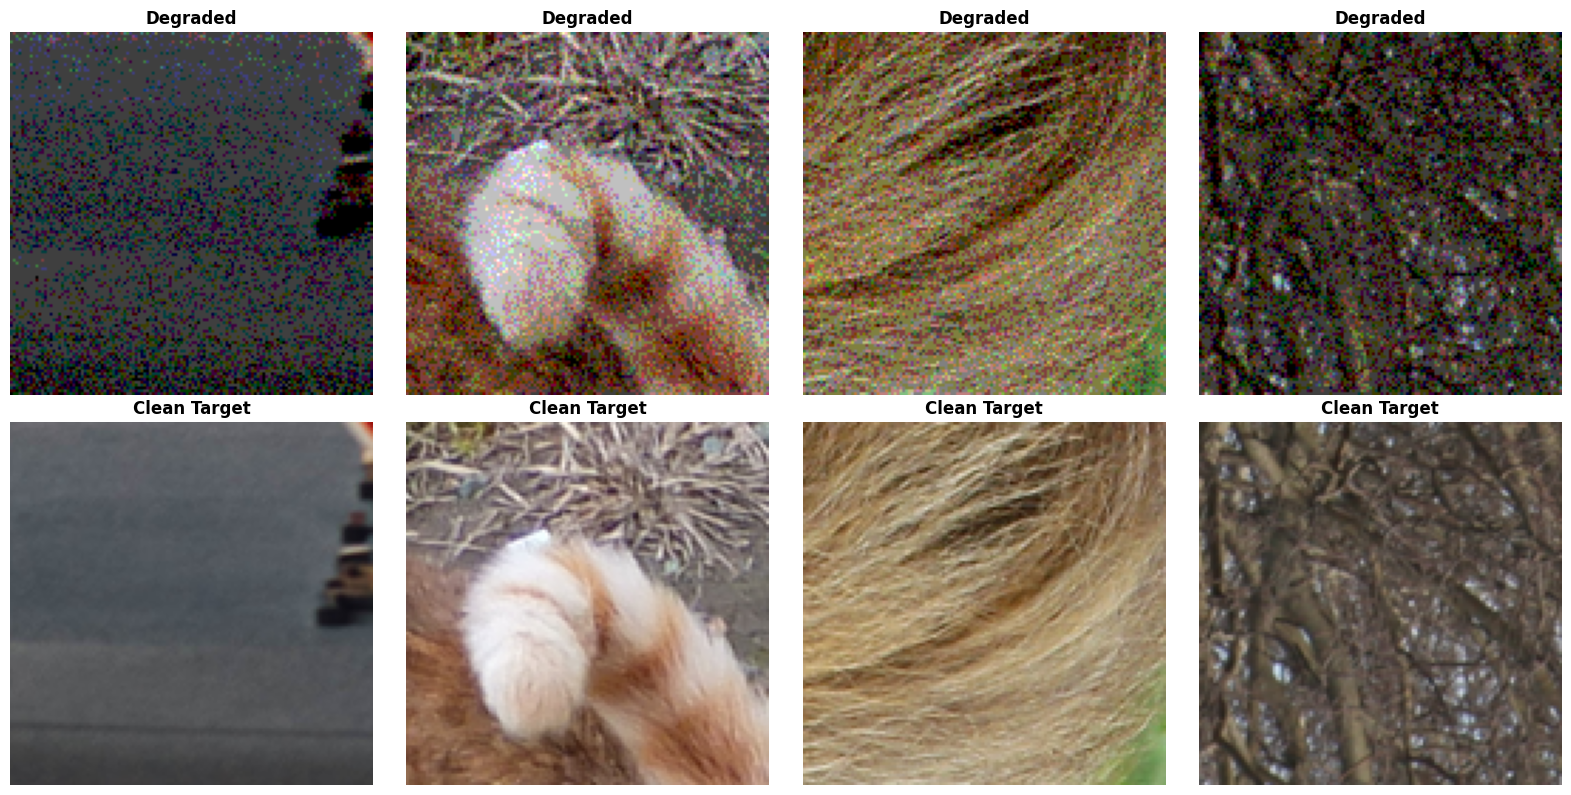


✅ Sample batch saved to ..\..\experiments\results\unet_dithering_20251228_152727\samples\training_samples.png


In [7]:
# Visualize a batch
degraded_batch, clean_batch = next(iter(train_loader))

print(f"Batch shapes:")
print(f"   Degraded: {degraded_batch.shape}")
print(f"   Clean: {clean_batch.shape}")
print(f"   Range: [{degraded_batch.min():.3f}, {degraded_batch.max():.3f}]")

# Show sample
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(4):
    # Denormalize for visualization (convert from [-1, 1] to [0, 1])
    # Tensors are in (C, H, W) format, convert to (H, W, C) for matplotlib
    deg_img = degraded_batch[i].cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    deg_img = (deg_img + 1) / 2  # [-1, 1] -> [0, 1]
    
    clean_img = clean_batch[i].cpu().numpy().transpose(1, 2, 0)
    clean_img = (clean_img + 1) / 2
    
    axes[0, i].imshow(np.clip(deg_img, 0, 1))
    axes[0, i].set_title('Degraded', fontweight='bold')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(np.clip(clean_img, 0, 1))
    axes[1, i].set_title('Clean Target', fontweight='bold')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig(samples_dir / 'training_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Sample batch saved to {samples_dir / 'training_samples.png'}")

## 8. Initialize Model, Loss, Optimizer

In [8]:
# Create model
model = UNet(
    in_channels=3,
    out_channels=3,
    features=config['model_features'],
    bilinear=config['model_bilinear']
).to(config['device'])

print(f"\n🤖 Model: UNet")
print(f"   Parameters: {model.get_num_params():,}")
print(f"   Device: {config['device']}")

# Loss function
criterion = CombinedLoss(
    alpha=config['loss_alpha'],
    beta=config['loss_beta']
).to(config['device'])

print(f"\n📉 Loss: L1 + SSIM (α={config['loss_alpha']}, β={config['loss_beta']})")

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay']
)

print(f"\n⚙️  Optimizer: AdamW")
print(f"   Learning rate: {config['learning_rate']}")
print(f"   Weight decay: {config['weight_decay']}")

# Learning rate scheduler
if config['scheduler'] == 'cosine':
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=config['num_epochs'] - config['warmup_epochs'],
        eta_min=config['min_lr']
    )
    print(f"\n📅 Scheduler: CosineAnnealingLR")
    print(f"   Warmup epochs: {config['warmup_epochs']}")
    print(f"   Min LR: {config['min_lr']}")


🤖 Model: UNet
   Parameters: 17,263,107
   Device: cuda

📉 Loss: L1 + SSIM (α=0.84, β=0.16)

⚙️  Optimizer: AdamW
   Learning rate: 0.0001
   Weight decay: 1e-05

📅 Scheduler: CosineAnnealingLR
   Warmup epochs: 5
   Min LR: 1e-06


## 9. Training Functions

In [9]:
def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """Train for one epoch"""
    model.train()
    
    running_loss = 0.0
    running_l1 = 0.0
    running_ssim = 0.0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1} [Train]', leave=False)
    
    for degraded, clean in pbar:
        degraded = degraded.to(device)
        clean = clean.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        output = model(degraded)
        
        # Compute loss
        loss, metrics = criterion(output, clean)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Update metrics
        running_loss += metrics['total']
        running_l1 += metrics['l1']
        running_ssim += metrics['ssim']
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f"{metrics['total']:.4f}",
            'l1': f"{metrics['l1']:.4f}",
            'ssim': f"{metrics['ssim']:.3f}"
        })
    
    # Average metrics
    n_batches = len(train_loader)
    avg_metrics = {
        'loss': running_loss / n_batches,
        'l1': running_l1 / n_batches,
        'ssim': running_ssim / n_batches
    }
    
    return avg_metrics


@torch.no_grad()
def validate(model, val_loader, criterion, device, epoch):
    """Validate the model"""
    model.eval()
    
    running_loss = 0.0
    running_l1 = 0.0
    running_ssim = 0.0
    
    pbar = tqdm(val_loader, desc=f'Epoch {epoch+1} [Val]', leave=False)
    
    for degraded, clean in pbar:
        degraded = degraded.to(device)
        clean = clean.to(device)
        
        # Forward pass
        output = model(degraded)
        
        # Compute loss
        loss, metrics = criterion(output, clean)
        
        # Update metrics
        running_loss += metrics['total']
        running_l1 += metrics['l1']
        running_ssim += metrics['ssim']
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f"{metrics['total']:.4f}",
            'ssim': f"{metrics['ssim']:.3f}"
        })
    
    # Average metrics
    n_batches = len(val_loader)
    avg_metrics = {
        'loss': running_loss / n_batches,
        'l1': running_l1 / n_batches,
        'ssim': running_ssim / n_batches
    }
    
    return avg_metrics


def save_checkpoint(model, optimizer, scheduler, epoch, metrics, filepath):
    """Save model checkpoint"""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'metrics': metrics
    }, filepath)


print("✅ Training functions defined")

✅ Training functions defined


## 10. Training Loop

In [10]:
# Training history
history = {
    'train_loss': [],
    'train_l1': [],
    'train_ssim': [],
    'val_loss': [],
    'val_l1': [],
    'val_ssim': [],
    'lr': []
}

# Best model tracking
best_val_loss = float('inf')
best_epoch = 0
patience_counter = 0

print("\n" + "="*80)
print("🚀 Starting Training")
print("="*80 + "\n")

try:
    for epoch in range(config['num_epochs']):
        
        # Learning rate warmup
        if epoch < config['warmup_epochs']:
            lr = config['learning_rate'] * (epoch + 1) / config['warmup_epochs']
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        
        # Train
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, 
                                    config['device'], epoch)
        
        # Validate
        if (epoch + 1) % config['val_every'] == 0:
            val_metrics = validate(model, val_loader, criterion, 
                                  config['device'], epoch)
        else:
            val_metrics = None
        
        # Update learning rate
        if epoch >= config['warmup_epochs'] and scheduler:
            scheduler.step()
        
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save metrics
        history['train_loss'].append(train_metrics['loss'])
        history['train_l1'].append(train_metrics['l1'])
        history['train_ssim'].append(train_metrics['ssim'])
        history['lr'].append(current_lr)
        
        if val_metrics:
            history['val_loss'].append(val_metrics['loss'])
            history['val_l1'].append(val_metrics['l1'])
            history['val_ssim'].append(val_metrics['ssim'])
        
        # Log to TensorBoard
        writer.add_scalar('Loss/train', train_metrics['loss'], epoch)
        writer.add_scalar('L1/train', train_metrics['l1'], epoch)
        writer.add_scalar('SSIM/train', train_metrics['ssim'], epoch)
        writer.add_scalar('Learning_Rate', current_lr, epoch)
        
        if val_metrics:
            writer.add_scalar('Loss/val', val_metrics['loss'], epoch)
            writer.add_scalar('L1/val', val_metrics['l1'], epoch)
            writer.add_scalar('SSIM/val', val_metrics['ssim'], epoch)
        
        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{config['num_epochs']}")
        print(f"  Train - Loss: {train_metrics['loss']:.4f} | L1: {train_metrics['l1']:.4f} | SSIM: {train_metrics['ssim']:.3f}")
        if val_metrics:
            print(f"  Val   - Loss: {val_metrics['loss']:.4f} | L1: {val_metrics['l1']:.4f} | SSIM: {val_metrics['ssim']:.3f}")
        print(f"  LR: {current_lr:.6f}")
        
        # Save checkpoint
        if val_metrics and val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            best_epoch = epoch
            patience_counter = 0
            
            save_checkpoint(
                model, optimizer, scheduler, epoch,
                {'train': train_metrics, 'val': val_metrics},
                checkpoints_dir / 'best_model.pth'
            )
            print(f"  ✅ Best model saved! (val_loss: {best_val_loss:.4f})")
        else:
            patience_counter += 1
        
        # Periodic checkpoint
        if (epoch + 1) % config['save_every'] == 0:
            save_checkpoint(
                model, optimizer, scheduler, epoch,
                {'train': train_metrics, 'val': val_metrics} if val_metrics else {'train': train_metrics},
                checkpoints_dir / f'checkpoint_epoch_{epoch+1:03d}.pth'
            )
            print(f"  💾 Checkpoint saved (epoch {epoch+1})")
        
        # Early stopping
        if patience_counter >= config['patience']:
            print(f"\n⚠️  Early stopping triggered! No improvement for {config['patience']} epochs.")
            break
        
        print("-" * 80)

except KeyboardInterrupt:
    print("\n⚠️  Training interrupted by user!")

print("\n" + "="*80)
print("✅ Training Completed!")
print(f"   Best validation loss: {best_val_loss:.4f} at epoch {best_epoch+1}")
print("="*80 + "\n")

# Close TensorBoard writer
writer.close()


🚀 Starting Training



Epoch 1 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 1/50
  Train - Loss: 0.2090 | L1: 0.1705 | SSIM: 0.589
  Val   - Loss: 0.1063 | L1: 0.0774 | SSIM: 0.742
  LR: 0.000020
  ✅ Best model saved! (val_loss: 0.1063)
--------------------------------------------------------------------------------


Epoch 2 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 2/50
  Train - Loss: 0.1314 | L1: 0.1088 | SSIM: 0.750
  Val   - Loss: 0.0936 | L1: 0.0711 | SSIM: 0.789
  LR: 0.000040
  ✅ Best model saved! (val_loss: 0.0936)
--------------------------------------------------------------------------------


Epoch 3 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 3/50
  Train - Loss: 0.1181 | L1: 0.0976 | SSIM: 0.775
  Val   - Loss: 0.0872 | L1: 0.0661 | SSIM: 0.802
  LR: 0.000060
  ✅ Best model saved! (val_loss: 0.0872)
--------------------------------------------------------------------------------


Epoch 4 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 4/50
  Train - Loss: 0.1099 | L1: 0.0908 | SSIM: 0.790
  Val   - Loss: 0.0898 | L1: 0.0684 | SSIM: 0.798
  LR: 0.000080
--------------------------------------------------------------------------------


Epoch 5 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 5/50
  Train - Loss: 0.1034 | L1: 0.0851 | SSIM: 0.801
  Val   - Loss: 0.0818 | L1: 0.0612 | SSIM: 0.810
  LR: 0.000100
  ✅ Best model saved! (val_loss: 0.0818)
  💾 Checkpoint saved (epoch 5)
--------------------------------------------------------------------------------


Epoch 6 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 6/50
  Train - Loss: 0.0992 | L1: 0.0815 | SSIM: 0.808
  Val   - Loss: 0.0783 | L1: 0.0583 | SSIM: 0.817
  LR: 0.000100
  ✅ Best model saved! (val_loss: 0.0783)
--------------------------------------------------------------------------------


Epoch 7 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 7/50
  Train - Loss: 0.0970 | L1: 0.0796 | SSIM: 0.812
  Val   - Loss: 0.0857 | L1: 0.0660 | SSIM: 0.811
  LR: 0.000100
--------------------------------------------------------------------------------


Epoch 8 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 8/50
  Train - Loss: 0.0956 | L1: 0.0779 | SSIM: 0.812
  Val   - Loss: 0.0783 | L1: 0.0592 | SSIM: 0.822
  LR: 0.000099
--------------------------------------------------------------------------------


Epoch 9 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 9/50
  Train - Loss: 0.0923 | L1: 0.0749 | SSIM: 0.817
  Val   - Loss: 0.0779 | L1: 0.0582 | SSIM: 0.819
  LR: 0.000098
  ✅ Best model saved! (val_loss: 0.0779)
--------------------------------------------------------------------------------


Epoch 10 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 10/50
  Train - Loss: 0.0893 | L1: 0.0723 | SSIM: 0.821
  Val   - Loss: 0.0767 | L1: 0.0579 | SSIM: 0.825
  LR: 0.000097
  ✅ Best model saved! (val_loss: 0.0767)
  💾 Checkpoint saved (epoch 10)
--------------------------------------------------------------------------------


Epoch 11 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 11/50
  Train - Loss: 0.0897 | L1: 0.0727 | SSIM: 0.821
  Val   - Loss: 0.0732 | L1: 0.0546 | SSIM: 0.829
  LR: 0.000096
  ✅ Best model saved! (val_loss: 0.0732)
--------------------------------------------------------------------------------


Epoch 12 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 12/50
  Train - Loss: 0.0886 | L1: 0.0719 | SSIM: 0.824
  Val   - Loss: 0.0726 | L1: 0.0539 | SSIM: 0.829
  LR: 0.000094
  ✅ Best model saved! (val_loss: 0.0726)
--------------------------------------------------------------------------------


Epoch 13 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 13 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 13/50
  Train - Loss: 0.0855 | L1: 0.0683 | SSIM: 0.824
  Val   - Loss: 0.0732 | L1: 0.0552 | SSIM: 0.833
  LR: 0.000092
--------------------------------------------------------------------------------


Epoch 14 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 14 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 14/50
  Train - Loss: 0.0850 | L1: 0.0680 | SSIM: 0.826
  Val   - Loss: 0.0751 | L1: 0.0557 | SSIM: 0.823
  LR: 0.000091
--------------------------------------------------------------------------------


Epoch 15 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 15 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 15/50
  Train - Loss: 0.0840 | L1: 0.0671 | SSIM: 0.827
  Val   - Loss: 0.0742 | L1: 0.0552 | SSIM: 0.826
  LR: 0.000088
  💾 Checkpoint saved (epoch 15)
--------------------------------------------------------------------------------


Epoch 16 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 16 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 16/50
  Train - Loss: 0.0807 | L1: 0.0640 | SSIM: 0.832
  Val   - Loss: 0.0714 | L1: 0.0528 | SSIM: 0.831
  LR: 0.000086
  ✅ Best model saved! (val_loss: 0.0714)
--------------------------------------------------------------------------------


Epoch 17 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 17 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 17/50
  Train - Loss: 0.0815 | L1: 0.0647 | SSIM: 0.830
  Val   - Loss: 0.0785 | L1: 0.0590 | SSIM: 0.819
  LR: 0.000084
--------------------------------------------------------------------------------


Epoch 18 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 18 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 18/50
  Train - Loss: 0.0796 | L1: 0.0628 | SSIM: 0.832
  Val   - Loss: 0.0754 | L1: 0.0566 | SSIM: 0.826
  LR: 0.000081
--------------------------------------------------------------------------------


Epoch 19 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 19 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 19/50
  Train - Loss: 0.0774 | L1: 0.0608 | SSIM: 0.835
  Val   - Loss: 0.0753 | L1: 0.0569 | SSIM: 0.828
  LR: 0.000078
--------------------------------------------------------------------------------


Epoch 20 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 20 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 20/50
  Train - Loss: 0.0779 | L1: 0.0616 | SSIM: 0.836
  Val   - Loss: 0.0698 | L1: 0.0518 | SSIM: 0.835
  LR: 0.000075
  ✅ Best model saved! (val_loss: 0.0698)
  💾 Checkpoint saved (epoch 20)
--------------------------------------------------------------------------------


Epoch 21 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 21/50
  Train - Loss: 0.0771 | L1: 0.0605 | SSIM: 0.835
  Val   - Loss: 0.0704 | L1: 0.0530 | SSIM: 0.838
  LR: 0.000072
--------------------------------------------------------------------------------


Epoch 22 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 22/50
  Train - Loss: 0.0763 | L1: 0.0597 | SSIM: 0.837
  Val   - Loss: 0.0698 | L1: 0.0526 | SSIM: 0.840
  LR: 0.000069
  ✅ Best model saved! (val_loss: 0.0698)
--------------------------------------------------------------------------------


Epoch 23 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 23/50
  Train - Loss: 0.0754 | L1: 0.0589 | SSIM: 0.838
  Val   - Loss: 0.0671 | L1: 0.0492 | SSIM: 0.839
  LR: 0.000066
  ✅ Best model saved! (val_loss: 0.0671)
--------------------------------------------------------------------------------


Epoch 24 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 24 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 24/50
  Train - Loss: 0.0750 | L1: 0.0585 | SSIM: 0.838
  Val   - Loss: 0.0752 | L1: 0.0560 | SSIM: 0.824
  LR: 0.000062
--------------------------------------------------------------------------------


Epoch 25 [Train]:   0%|          | 0/500 [00:00<?, ?it/s]


⚠️  Training interrupted by user!

✅ Training Completed!
   Best validation loss: 0.0671 at epoch 23



## 11. Save Training History

In [11]:
# Save history
with open(exp_dir / 'history.json', 'w') as f:
    json.dump(history, f, indent=2)

print(f"✅ Training history saved to {exp_dir / 'history.json'}")

✅ Training history saved to ..\..\experiments\results\unet_dithering_20251228_152727\history.json


## 12. Plot Training Curves

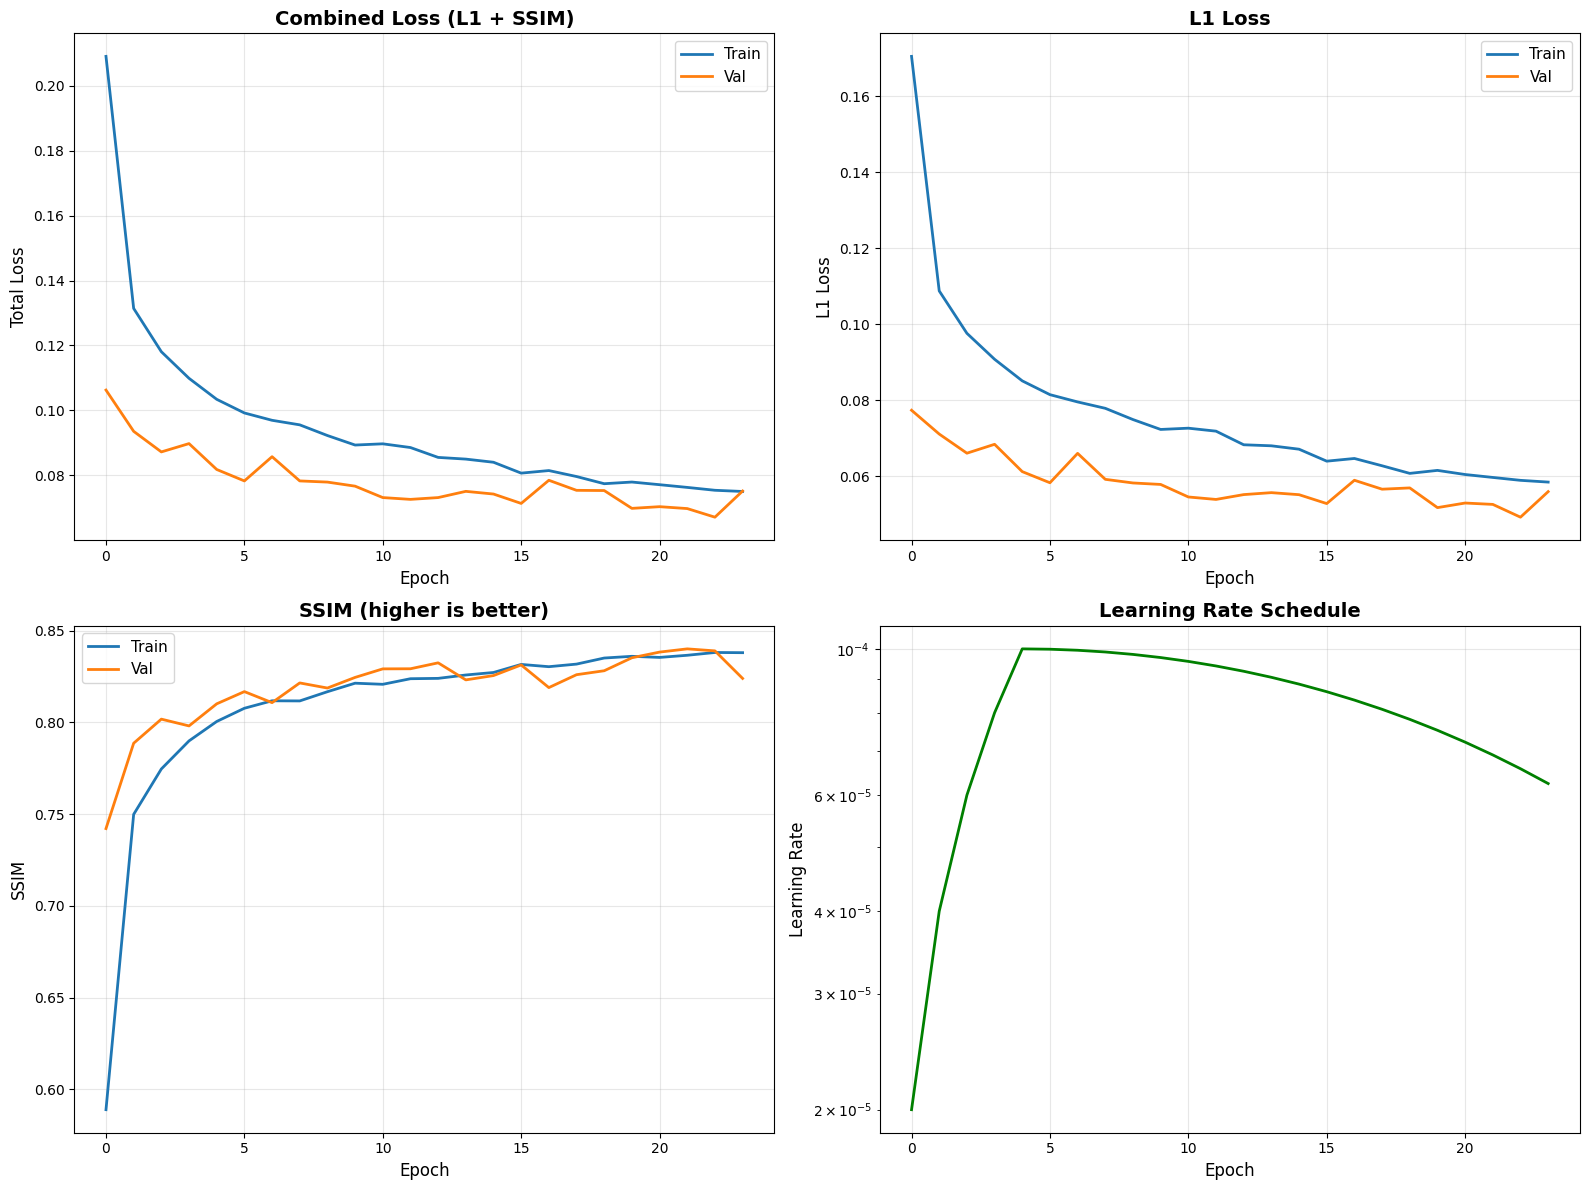


✅ Training curves saved to ..\..\experiments\results\unet_dithering_20251228_152727\training_curves.png


In [12]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Val', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Total Loss', fontsize=12)
axes[0, 0].set_title('Combined Loss (L1 + SSIM)', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(alpha=0.3)

# L1
axes[0, 1].plot(history['train_l1'], label='Train', linewidth=2)
axes[0, 1].plot(history['val_l1'], label='Val', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('L1 Loss', fontsize=12)
axes[0, 1].set_title('L1 Loss', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(alpha=0.3)

# SSIM
axes[1, 0].plot(history['train_ssim'], label='Train', linewidth=2)
axes[1, 0].plot(history['val_ssim'], label='Val', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('SSIM', fontsize=12)
axes[1, 0].set_title('SSIM (higher is better)', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(alpha=0.3)

# Learning rate
axes[1, 1].plot(history['lr'], linewidth=2, color='green')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(exp_dir / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Training curves saved to {exp_dir / 'training_curves.png'}")

## 13. Test Inference on Validation Samples

✅ Loaded best model from epoch 23


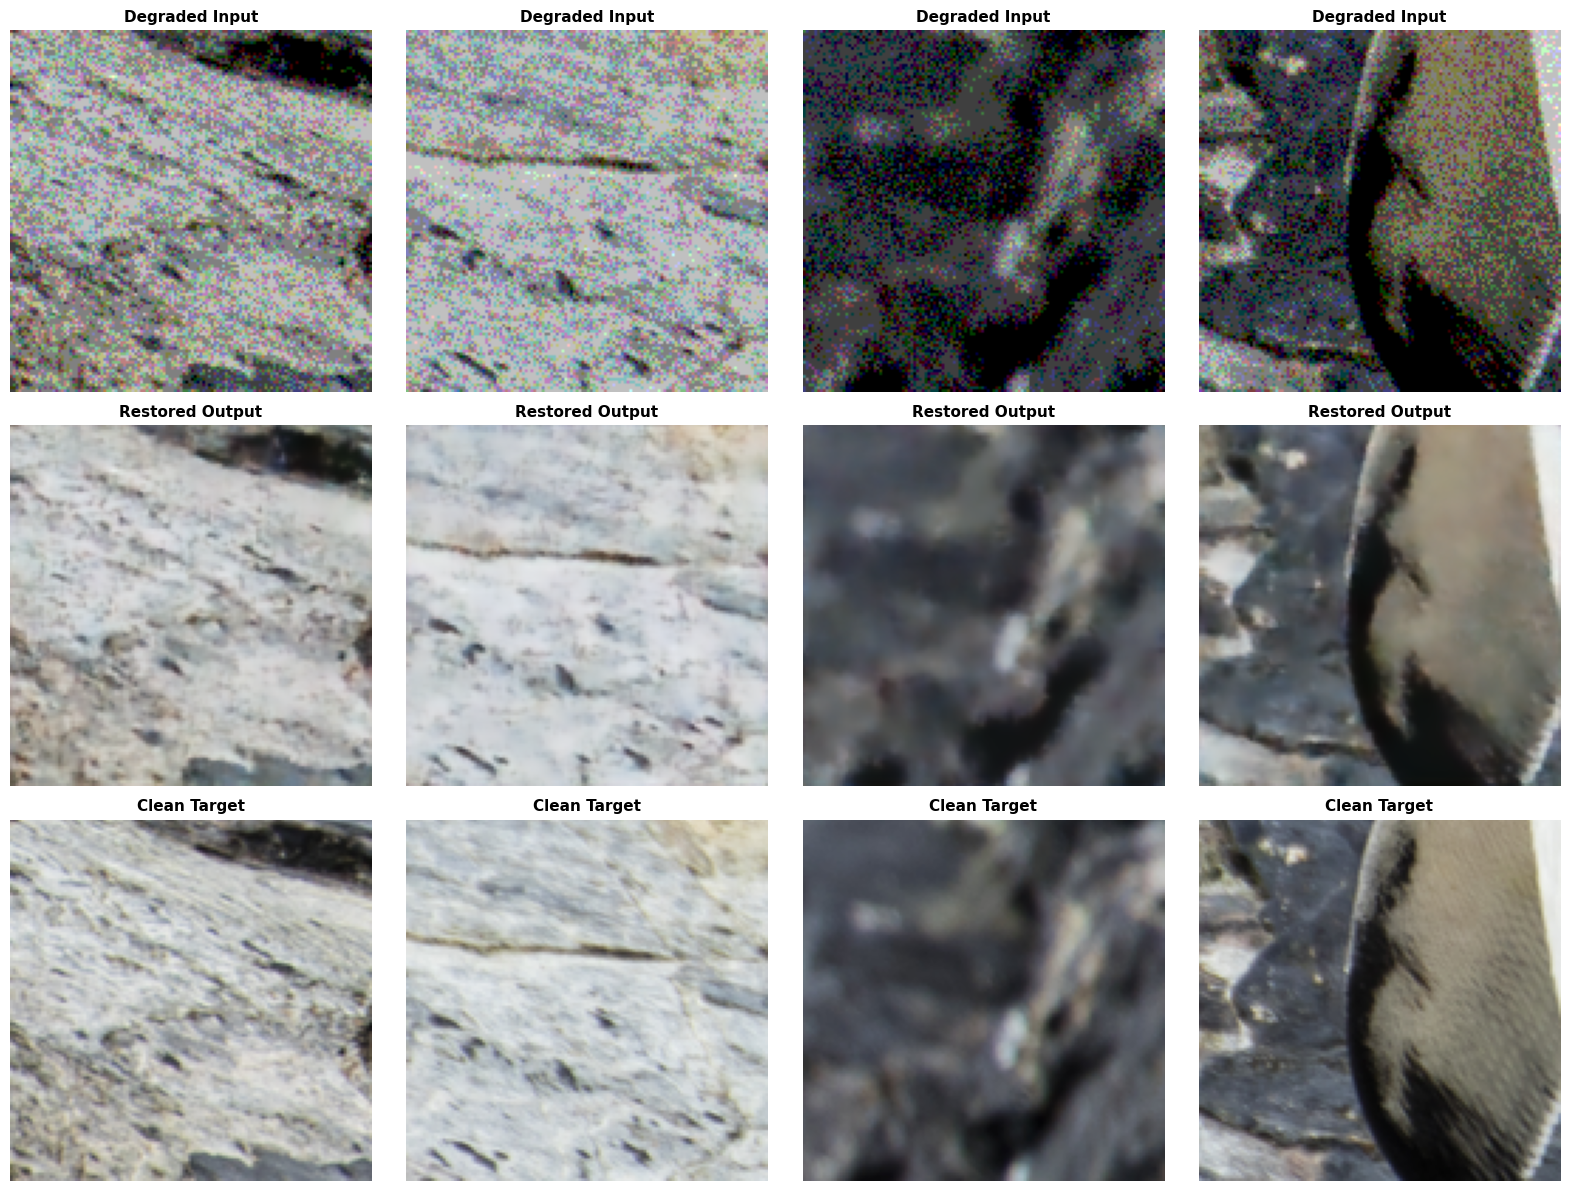


✅ Inference results saved to ..\..\experiments\results\unet_dithering_20251228_152727\samples\inference_results.png


In [13]:
# Load best model
checkpoint = torch.load(checkpoints_dir / 'best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Loaded best model from epoch {checkpoint['epoch']+1}")

# Get validation batch
degraded_batch, clean_batch = next(iter(val_loader))
degraded_batch = degraded_batch.to(config['device'])
clean_batch = clean_batch.to(config['device'])

# Inference
with torch.no_grad():
    restored_batch = model(degraded_batch)

# Visualize results
n_samples = min(4, len(degraded_batch))
fig, axes = plt.subplots(3, n_samples, figsize=(4*n_samples, 12))

for i in range(n_samples):
    # Denormalize and convert from (C, H, W) to (H, W, C)
    deg = degraded_batch[i].cpu().numpy().transpose(1, 2, 0)
    deg = (deg + 1) / 2
    
    clean = clean_batch[i].cpu().numpy().transpose(1, 2, 0)
    clean = (clean + 1) / 2
    
    restored = restored_batch[i].cpu().numpy().transpose(1, 2, 0)
    restored = (restored + 1) / 2
    
    # Degraded
    axes[0, i].imshow(np.clip(deg, 0, 1))
    axes[0, i].set_title('Degraded Input', fontweight='bold', fontsize=11)
    axes[0, i].axis('off')
    
    # Restored
    axes[1, i].imshow(np.clip(restored, 0, 1))
    axes[1, i].set_title('Restored Output', fontweight='bold', fontsize=11)
    axes[1, i].axis('off')
    
    # Clean target
    axes[2, i].imshow(np.clip(clean, 0, 1))
    axes[2, i].set_title('Clean Target', fontweight='bold', fontsize=11)
    axes[2, i].axis('off')

plt.tight_layout()
plt.savefig(samples_dir / 'inference_results.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Inference results saved to {samples_dir / 'inference_results.png'}")

## 14. Summary

In [14]:
print("\n" + "="*80)
print("📊 TRAINING SUMMARY")
print("="*80)
print(f"\nExperiment: {exp_name}")
print(f"Directory: {exp_dir}")
print(f"\nTraining completed: {len(history['train_loss'])} epochs")
print(f"Best epoch: {best_epoch + 1}")
print(f"\nBest Validation Metrics:")
print(f"  Loss: {best_val_loss:.4f}")
print(f"  L1: {history['val_l1'][best_epoch]:.4f}")
print(f"  SSIM: {history['val_ssim'][best_epoch]:.4f}")
print(f"\nFinal Training Metrics:")
print(f"  Loss: {history['train_loss'][-1]:.4f}")
print(f"  L1: {history['train_l1'][-1]:.4f}")
print(f"  SSIM: {history['train_ssim'][-1]:.4f}")
print(f"\nSaved files:")
print(f"  ✓ Best model: {checkpoints_dir / 'best_model.pth'}")
print(f"  ✓ Training history: {exp_dir / 'history.json'}")
print(f"  ✓ Training curves: {exp_dir / 'training_curves.png'}")
print(f"  ✓ Inference samples: {samples_dir / 'inference_results.png'}")
print(f"  ✓ TensorBoard logs: {logs_dir}")
print("\n" + "="*80)
print("🎉 All done!")
print("="*80)


📊 TRAINING SUMMARY

Experiment: unet_dithering_20251228_152727
Directory: ..\..\experiments\results\unet_dithering_20251228_152727

Training completed: 24 epochs
Best epoch: 23

Best Validation Metrics:
  Loss: 0.0671
  L1: 0.0492
  SSIM: 0.8390

Final Training Metrics:
  Loss: 0.0750
  L1: 0.0585
  SSIM: 0.8381

Saved files:
  ✓ Best model: ..\..\experiments\results\unet_dithering_20251228_152727\checkpoints\best_model.pth
  ✓ Training history: ..\..\experiments\results\unet_dithering_20251228_152727\history.json
  ✓ Training curves: ..\..\experiments\results\unet_dithering_20251228_152727\training_curves.png
  ✓ Inference samples: ..\..\experiments\results\unet_dithering_20251228_152727\samples\inference_results.png
  ✓ TensorBoard logs: ..\..\experiments\results\unet_dithering_20251228_152727\logs

🎉 All done!
